# Дипломный проект Некрасов А.В.

## Predicting flight delays
Данные - https://www.kaggle.com/usdot/flight-delays
Описание - Сводная информация о количестве своевременных, задержанных, отмененных и измененных рейсов в США за 2015 год (5.8 млн записей)

### Задачи:

1 Найти аэропорт с минимальной задержкой вылета

2 Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport

3 Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)

4 Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика),  в зависимости от аэропорта вылета  

#### Ход работ

Импортируем необходимые билиотеки

In [2]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('flights.csv', low_memory=False)

In [4]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.252978,0.0,0.0,0.0,1.480526,1.480526,1.530259,1.530259,0.000103,1.805629,1.805629,0.0,1.589822,1.589822,0.0,1.589822,1.805629,0.0,0.0,98.455357,81.72496,81.72496,81.72496,81.72496,81.72496


#### Data Definition

WHEELS_OFF Time - The time point that the aircraft's wheels leave the ground.

WHEELS_ON Time - The time point that the aircraft's wheels touch on the ground.

TAXI_OUT Time - The time duration elapsed between departure from the origin airport gate and wheels off.

TAXI_IN Time - The time duration elapsed between wheels-on and gate arrival at the destination airport.

AIR_TIME - The time duration between wheels_off and wheels_on time.

#### Data Relationship

arrival_time = wheels_on + taxi_in

arrival_delay = arrival_time - scheduled_arrival

departure_time = wheels_off - taxi_out

departure_delay = departure_time - scheduled_departure

elapsed_time =air_time + taxi_in + taxi_out

air_time = wheels_on - wheels_off

In [4]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [5]:
#_________________________________________________________
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [6]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
df['WHEELS_OFF'] = df['WHEELS_OFF'].apply(format_heure)
df['WHEELS_ON'] = df['WHEELS_ON'].apply(format_heure)

In [5]:
airport_id_df = pd.read_csv("L_AIRPORT_ID.csv")
airport_df = pd.read_csv("L_AIRPORT.csv")

df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']] = df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']].astype(str)
airport_id_df[['Code', 'Description']] = airport_id_df[['Code', 'Description']].astype(str)
airport_df[['Code', 'Description']] = airport_df[['Code', 'Description']].astype(str)


In [6]:
# Сoncat the airport codes reference books
concat_df = pd.concat([airport_id_df, airport_df], axis=0)

In [7]:
# Create a dictionary to map airport codes to unique markings
airport_mapping = dict(zip(concat_df['Code'], concat_df['Description']))
airport_mapping_letter_code = dict(zip(airport_df['Description'], airport_df['Code']))

In [8]:
# Apply the mapping to the departure and arrival airport columns in the dataset
df['Departure_Description'] = df['ORIGIN_AIRPORT'].map(airport_mapping)
df['Arrival_Description'] = df['DESTINATION_AIRPORT'].map(airport_mapping)
df['Departure_Marking'] = df['Departure_Description'].map(airport_mapping_letter_code)
df['Arrival_Marking'] = df['Arrival_Description'].map(airport_mapping_letter_code)

In [10]:
variables_to_remove = ['Departure_Description', 'Arrival_Description', 'DESTINATION_AIRPORT' , 'ORIGIN_AIRPORT',
                      'CANCELLATION_REASON', 
                       'WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY', 
                       'AIRLINE_DELAY',  'SECURITY_DELAY', 'AIR_SYSTEM_DELAY']

df.drop(variables_to_remove, axis = 1, inplace = True)

df.rename(columns = {'Departure_Marking' : 'ORIGIN_AIRPORT', 'Arrival_Marking' : 'DESTINATION_AIRPORT' }, inplace = True)

In [11]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,105071,98.194371
1,ELAPSED_TIME,105071,98.194371
2,AIR_TIME,105071,98.194371
3,ARRIVAL_TIME,92513,98.410178
4,TAXI_IN,92513,98.410178
5,WHEELS_ON,92513,98.410178
6,TAXI_OUT,89047,98.469741
7,WHEELS_OFF,89047,98.469741
8,DEPARTURE_TIME,86153,98.519474
9,DEPARTURE_DELAY,86153,98.519474


In [12]:
df.columns.values.tolist()

['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT']

In [13]:
df = df[['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',      
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED']]

In [14]:
df.to_csv("clean_flights.csv", index=False)

### 1 Найти аэропорт с минимальной задержкой вылета

In [33]:
df = pd.read_csv('clean_flights.csv')

In [15]:
delay_airport_df = df[['ORIGIN_AIRPORT', 'DEPARTURE_DELAY']]

In [16]:
delay_airport_df.isnull().sum()

ORIGIN_AIRPORT         0
DEPARTURE_DELAY    86153
dtype: int64

In [17]:
delay_airport_df.dropna(inplace = True)

In [18]:
#аэропорт с минимальной задержкой вылета
min_delay_airport_df = delay_airport_df.groupby('ORIGIN_AIRPORT').min().sort_values(by = 'DEPARTURE_DELAY')
min_delay_airport_df.head(1)

,DEPARTURE_DELAY
ORIGIN_AIRPORT,
ADK,-82.0


### 2 Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport

In [19]:
airlines_names = pd.read_csv('airlines.csv')
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()
companies_names = airlines_names.set_index('AIRLINE')['IATA_CODE'].to_dict()

In [20]:
lax_arrival_delay_df = df.loc[df['DESTINATION_AIRPORT'].isin(['LAX'])]
lax_arrival_delay_df = lax_arrival_delay_df[[ 'AIRLINE', 'ARRIVAL_DELAY']]

In [21]:
lax_arrival_delay_df['AIRLINE'] = lax_arrival_delay_df['AIRLINE'].map(abbr_companies)

In [22]:
lax_arrival_delay_df.dropna(inplace = True)

In [23]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean(), 'median': group.median()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = lax_arrival_delay_df['ARRIVAL_DELAY'].groupby(lax_arrival_delay_df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('mean', ascending=True)
global_stats

,min,max,count,mean,median
AIRLINE,,,,,
Hawaiian Airlines Inc.,-57.0,323.0,1673.0,-4.653317,-9.0
Alaska Airlines Inc.,-71.0,599.0,8969.0,-0.525700,-5.0
JetBlue Airways,-74.0,522.0,4424.0,-0.022152,-7.0
Delta Air Lines Inc.,-79.0,1045.0,27720.0,1.398882,-6.0
American Airlines Inc.,-73.0,1636.0,35619.0,2.122856,-7.0
US Airways Inc.,-65.0,309.0,3656.0,3.039387,-4.0
Virgin America,-81.0,651.0,12835.0,3.852513,-3.0
United Air Lines Inc.,-81.0,1185.0,29645.0,7.800304,-2.0
Southwest Airlines Co.,-58.0,502.0,40139.0,8.143601,0.0


In [24]:
#Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport
global_stats.head(1)

,min,max,count,mean,median
AIRLINE,,,,,
Hawaiian Airlines Inc.,-57.0,323.0,1673.0,-4.653317,-9.0


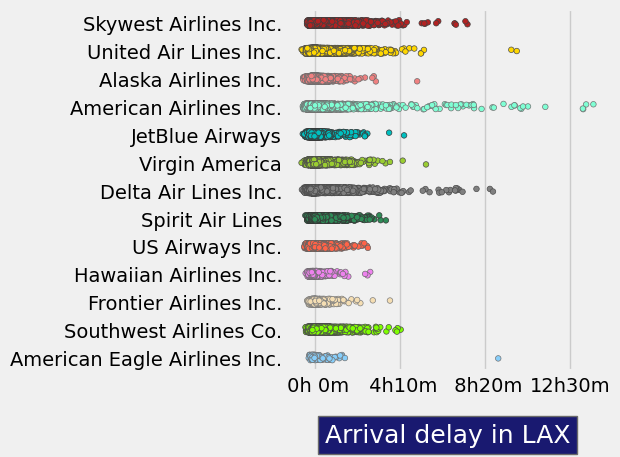

In [25]:
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="ARRIVAL_DELAY", size = 4, palette = colors,
                    data=lax_arrival_delay_df, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Arrival delay in LAX', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3)

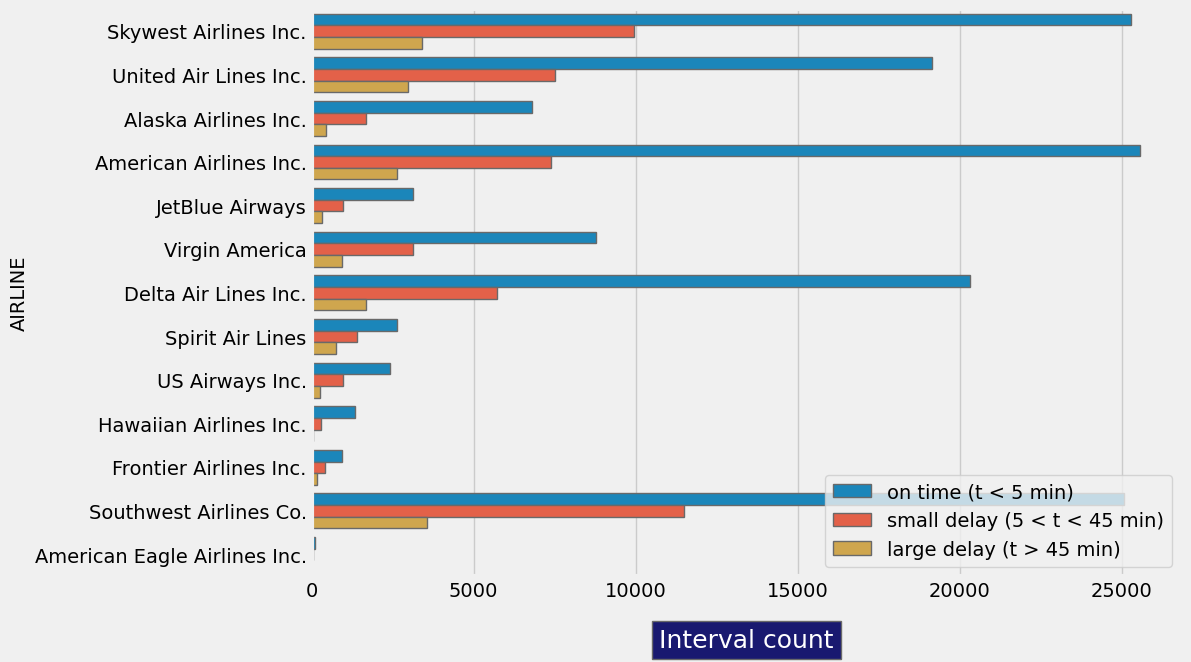

In [26]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
lax_arrival_delay_df['DELAY_LEVEL'] = lax_arrival_delay_df['ARRIVAL_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=lax_arrival_delay_df)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.xlabel('Interval count', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
plt.show()


### 3 Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)

In [27]:
taxi_out_airport_df = df[['ORIGIN_AIRPORT', 'TAXI_OUT']]
taxi_in_airport_df = df[['DESTINATION_AIRPORT', 'TAXI_IN']]

taxi_out_airport_df.rename(columns = {'ORIGIN_AIRPORT' : 'AIRPORT', 'TAXI_OUT' : 'TAXI'}, inplace = True)
taxi_in_airport_df.rename(columns = {'DESTINATION_AIRPORT' : 'AIRPORT', 'TAXI_IN' : 'TAXI'}, inplace = True)

In [28]:
taxi_in_out_airport_df = pd.concat([taxi_out_airport_df, taxi_in_airport_df], axis=0)
taxi_in_out_airport_df.dropna()

,AIRPORT,TAXI
0,ANC,21.0
1,LAX,12.0
2,SFO,16.0
3,LAX,15.0
4,SEA,11.0
...,...,...
5819074,BOS,4.0
5819075,PSE,3.0
5819076,SJU,8.0
5819077,SJU,3.0


In [29]:
#аэропорт, где самолёты проводят больше всего времени на рулении
taxi_in_out_airport_df.groupby('AIRPORT').mean().sort_values(by = 'TAXI', ascending = False).head(1)

,TAXI
AIRPORT,
LGA,17.788691


In [30]:
lga_taxi_in_out_airport_df = taxi_in_out_airport_df.loc[taxi_in_out_airport_df['AIRPORT'].isin(['LGA'])]

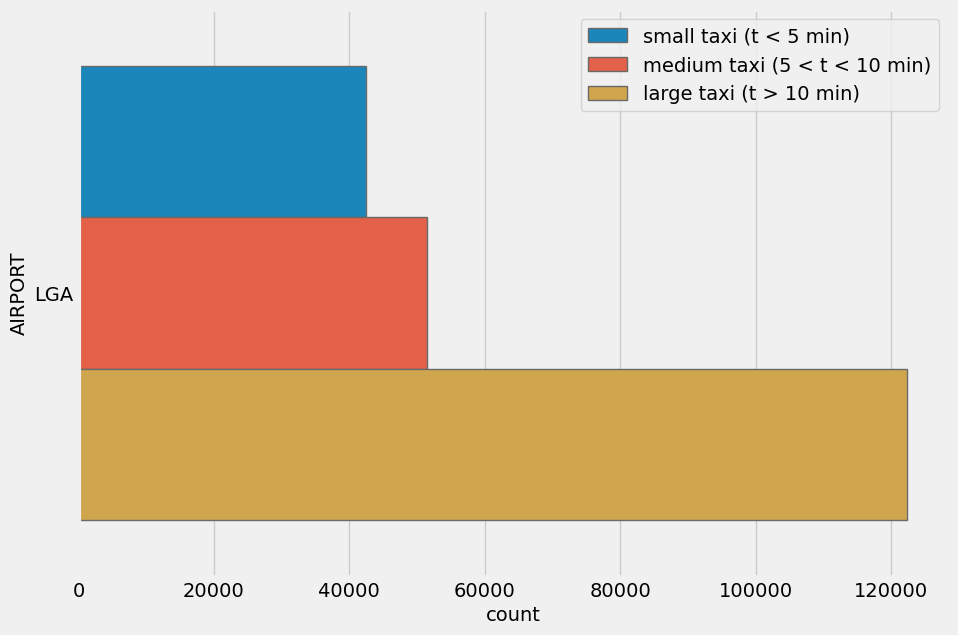

In [31]:
#_____________________________________________
# Function that define how delays are grouped
taxi_type = lambda x:((0,1)[x > 5],2)[x > 10]
lga_taxi_in_out_airport_df['TAXI_LEVEL'] = lga_taxi_in_out_airport_df['TAXI'].apply(taxi_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRPORT", hue='TAXI_LEVEL', data=lga_taxi_in_out_airport_df)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('small taxi (t < 5 min)')
L.get_texts()[1].set_text('medium taxi (5 < t < 10 min)')
L.get_texts()[2].set_text('large taxi (t > 10 min)')
plt.show()

### 4 Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика), в зависимости от аэропорта вылета

При прогнозировании задержек рейсов обычно рекомендуется исключать отмененные и измененные рейсы из набора данных, используемого для обучения и прогнозирования. Это связано с тем, что для отмененных рейсов нельзя предсказать значение задержки, а для рейсов с измененным маршрутом могут быть разные факторы, влияющие на время задержки.

Включение отмененных рейсов в набор данных может внести шум и повлиять на точность прогнозов. Более того, если целью является прогнозирование задержек в оперативных целях, включение отмененных рейсов может не дать значимой информации.

Точно так же перенаправленные рейсы могут иметь разные аэропорты вылета и прибытия, что может существенно повлиять на характер задержек. Причины изменения маршрута, такие как погодные условия или эксплуатационные ограничения, также могут отличаться от обычных рейсов. Включение перенаправленных рейсов в набор данных может привести к необъективным прогнозам и может неточно отражать типичные модели задержек.


In [32]:
# подготовка данных
#df = pd.get_dummies(df, columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT' ], drop_first=True)
preprocessed_flights_df = df

In [33]:
preprocessed_flights_df.drop(['TAIL_NUMBER', 'FLIGHT_NUMBER','DIVERTED', 'CANCELLED'], axis = 1, inplace = True)


In [34]:
#Удаляем строки с пустыми знчениями
# ! ВАЖНО 
preprocessed_flights_df.dropna(inplace = True)

In [36]:
# Save the preprocessed data to a new CSV file
preprocessed_flights_df.to_csv("preprocessed_flights.csv", index=False)

In [ ]:
# Load the preprocessed dataset
df = pd.read_csv("preprocessed_flights.csv")

In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [82]:
# Select the departure airport for analysis
origin_airport = 'JFK'  # Specify the departure airport code

# Filter the dataset for the selected departure airport
df_origin = preprocessed_flights_df[preprocessed_flights_df['ORIGIN_AIRPORT'] == origin_airport]

In [83]:
df_origin

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
97,2015,1,1,4,B6,JFK,SJU,535,618.0,43.0,13.0,631.0,225.0,201.0,184.0,1598,1035.0,4.0,1020,1039.0,19.0
120,2015,1,1,4,AA,JFK,MIA,545,640.0,55.0,17.0,657.0,185.0,199.0,152.0,1089,929.0,30.0,850,959.0,69.0
123,2015,1,1,4,B6,JFK,BQN,545,545.0,0.0,17.0,602.0,221.0,202.0,180.0,1576,1002.0,5.0,1026,1007.0,-19.0
238,2015,1,1,4,B6,JFK,PBI,600,554.0,-6.0,16.0,610.0,178.0,162.0,142.0,1028,832.0,4.0,858,836.0,-22.0
243,2015,1,1,4,B6,JFK,MCO,600,557.0,-3.0,16.0,613.0,171.0,155.0,135.0,944,828.0,4.0,851,832.0,-19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818939,2015,12,31,4,B6,JFK,BUF,2250,2307.0,17.0,14.0,2321.0,83.0,79.0,61.0,301,22.0,4.0,13,26.0,13.0
5818980,2015,12,31,4,B6,JFK,BOS,2312,2307.0,-5.0,16.0,2323.0,64.0,54.0,33.0,187,2356.0,5.0,16,1.0,-15.0
5819075,2015,12,31,4,B6,JFK,PSE,2359,2355.0,-4.0,17.0,12.0,227.0,215.0,195.0,1617,427.0,3.0,446,430.0,-16.0
5819076,2015,12,31,4,B6,JFK,SJU,2359,2350.0,-9.0,17.0,7.0,221.0,222.0,197.0,1598,424.0,8.0,440,432.0,-8.0


In [84]:
df_encoded = df_origin[['DESTINATION_AIRPORT', 'AIRLINE']].copy()
df_encoded = pd.get_dummies(df_encoded, columns=['DESTINATION_AIRPORT', 'AIRLINE' ])

In [85]:
df_encoded

,DESTINATION_AIRPORT_ABQ,DESTINATION_AIRPORT_ACK,DESTINATION_AIRPORT_ATL,DESTINATION_AIRPORT_BNA,DESTINATION_AIRPORT_BOS,DESTINATION_AIRPORT_BQN,DESTINATION_AIRPORT_BSM,DESTINATION_AIRPORT_BTV,DESTINATION_AIRPORT_BUF,DESTINATION_AIRPORT_BUR,DESTINATION_AIRPORT_BWI,DESTINATION_AIRPORT_CHS,DESTINATION_AIRPORT_CLE,DESTINATION_AIRPORT_CLT,DESTINATION_AIRPORT_CMH,DESTINATION_AIRPORT_CVG,DESTINATION_AIRPORT_DCA,DESTINATION_AIRPORT_DEN,DESTINATION_AIRPORT_DFW,DESTINATION_AIRPORT_DTW,DESTINATION_AIRPORT_EGE,DESTINATION_AIRPORT_FLL,DESTINATION_AIRPORT_HNL,DESTINATION_AIRPORT_HOU,DESTINATION_AIRPORT_HYA,...,DESTINATION_AIRPORT_RNO,DESTINATION_AIRPORT_ROC,DESTINATION_AIRPORT_RSW,DESTINATION_AIRPORT_SAN,DESTINATION_AIRPORT_SAT,DESTINATION_AIRPORT_SAV,DESTINATION_AIRPORT_SEA,DESTINATION_AIRPORT_SFO,DESTINATION_AIRPORT_SJC,DESTINATION_AIRPORT_SJU,DESTINATION_AIRPORT_SLC,DESTINATION_AIRPORT_SMF,DESTINATION_AIRPORT_SRQ,DESTINATION_AIRPORT_STT,DESTINATION_AIRPORT_SYR,DESTINATION_AIRPORT_TPA,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_HA,AIRLINE_MQ,AIRLINE_UA,AIRLINE_US,AIRLINE_VX
97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
120,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
123,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
238,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818939,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5818980,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5819075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5819076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [86]:
df_encoded = pd.concat([df_origin, df_encoded], axis=1)

In [87]:
df_encoded

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DESTINATION_AIRPORT_ABQ,DESTINATION_AIRPORT_ACK,DESTINATION_AIRPORT_ATL,DESTINATION_AIRPORT_BNA,...,DESTINATION_AIRPORT_RNO,DESTINATION_AIRPORT_ROC,DESTINATION_AIRPORT_RSW,DESTINATION_AIRPORT_SAN,DESTINATION_AIRPORT_SAT,DESTINATION_AIRPORT_SAV,DESTINATION_AIRPORT_SEA,DESTINATION_AIRPORT_SFO,DESTINATION_AIRPORT_SJC,DESTINATION_AIRPORT_SJU,DESTINATION_AIRPORT_SLC,DESTINATION_AIRPORT_SMF,DESTINATION_AIRPORT_SRQ,DESTINATION_AIRPORT_STT,DESTINATION_AIRPORT_SYR,DESTINATION_AIRPORT_TPA,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_HA,AIRLINE_MQ,AIRLINE_UA,AIRLINE_US,AIRLINE_VX
97,2015,1,1,4,B6,JFK,SJU,535,618.0,43.0,13.0,631.0,225.0,201.0,184.0,1598,1035.0,4.0,1020,1039.0,19.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
120,2015,1,1,4,AA,JFK,MIA,545,640.0,55.0,17.0,657.0,185.0,199.0,152.0,1089,929.0,30.0,850,959.0,69.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
123,2015,1,1,4,B6,JFK,BQN,545,545.0,0.0,17.0,602.0,221.0,202.0,180.0,1576,1002.0,5.0,1026,1007.0,-19.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
238,2015,1,1,4,B6,JFK,PBI,600,554.0,-6.0,16.0,610.0,178.0,162.0,142.0,1028,832.0,4.0,858,836.0,-22.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
243,2015,1,1,4,B6,JFK,MCO,600,557.0,-3.0,16.0,613.0,171.0,155.0,135.0,944,828.0,4.0,851,832.0,-19.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818939,2015,12,31,4,B6,JFK,BUF,2250,2307.0,17.0,14.0,2321.0,83.0,79.0,61.0,301,22.0,4.0,13,26.0,13.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5818980,2015,12,31,4,B6,JFK,BOS,2312,2307.0,-5.0,16.0,2323.0,64.0,54.0,33.0,187,2356.0,5.0,16,1.0,-15.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5819075,2015,12,31,4,B6,JFK,PSE,2359,2355.0,-4.0,17.0,12.0,227.0,215.0,195.0,1617,427.0,3.0,446,430.0,-16.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5819076,2015,12,31,4,B6,JFK,SJU,2359,2350.0,-9.0,17.0,7.0,221.0,222.0,197.0,1598,424.0,8.0,440,432.0,-8.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [43]:
#df_encoded.columns.values.tolist()

In [88]:
features = ['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DESTINATION_AIRPORT_ABQ',
 'DESTINATION_AIRPORT_ACK',
 'DESTINATION_AIRPORT_ATL',
 'DESTINATION_AIRPORT_BNA',
 'DESTINATION_AIRPORT_BOS',
 'DESTINATION_AIRPORT_BQN',
 'DESTINATION_AIRPORT_BSM',
 'DESTINATION_AIRPORT_BTV',
 'DESTINATION_AIRPORT_BUF',
 'DESTINATION_AIRPORT_BUR',
 'DESTINATION_AIRPORT_BWI',
 'DESTINATION_AIRPORT_CHS',
 'DESTINATION_AIRPORT_CLE',
 'DESTINATION_AIRPORT_CLT',
 'DESTINATION_AIRPORT_CMH',
 'DESTINATION_AIRPORT_CVG',
 'DESTINATION_AIRPORT_DCA',
 'DESTINATION_AIRPORT_DEN',
 'DESTINATION_AIRPORT_DFW',
 'DESTINATION_AIRPORT_DTW',
 'DESTINATION_AIRPORT_EGE',
 'DESTINATION_AIRPORT_FLL',
 'DESTINATION_AIRPORT_HNL',
 'DESTINATION_AIRPORT_HOU',
 'DESTINATION_AIRPORT_HYA',
 'DESTINATION_AIRPORT_IAD',
 'DESTINATION_AIRPORT_IND',
 'DESTINATION_AIRPORT_JAC',
 'DESTINATION_AIRPORT_JAX',
 'DESTINATION_AIRPORT_LAS',
 'DESTINATION_AIRPORT_LAX',
 'DESTINATION_AIRPORT_LGB',
 'DESTINATION_AIRPORT_MCO',
 'DESTINATION_AIRPORT_MIA',
 'DESTINATION_AIRPORT_MSP',
 'DESTINATION_AIRPORT_MSY',
 'DESTINATION_AIRPORT_MVY',
 'DESTINATION_AIRPORT_OAK',
 'DESTINATION_AIRPORT_ORD',
 'DESTINATION_AIRPORT_ORF',
 'DESTINATION_AIRPORT_PBI',
 'DESTINATION_AIRPORT_PDX',
 'DESTINATION_AIRPORT_PHX',
 'DESTINATION_AIRPORT_PIT',
 'DESTINATION_AIRPORT_PSE',
 'DESTINATION_AIRPORT_PSP',
 'DESTINATION_AIRPORT_PWM',
 'DESTINATION_AIRPORT_RDU',
 'DESTINATION_AIRPORT_RNO',
 'DESTINATION_AIRPORT_ROC',
 'DESTINATION_AIRPORT_RSW',
 'DESTINATION_AIRPORT_SAN',
 'DESTINATION_AIRPORT_SAT',
 'DESTINATION_AIRPORT_SAV',
 'DESTINATION_AIRPORT_SEA',
 'DESTINATION_AIRPORT_SFO',
 'DESTINATION_AIRPORT_SJC',
 'DESTINATION_AIRPORT_SJU',
 'DESTINATION_AIRPORT_SLC',
 'DESTINATION_AIRPORT_SMF',
 'DESTINATION_AIRPORT_SRQ',
 'DESTINATION_AIRPORT_STT',
 'DESTINATION_AIRPORT_SYR',
 'DESTINATION_AIRPORT_TPA',
 'AIRLINE_AA',
 'AIRLINE_AS',
 'AIRLINE_B6',
 'AIRLINE_DL',
 'AIRLINE_HA',
 'AIRLINE_MQ',
 'AIRLINE_UA',
 'AIRLINE_US',
 'AIRLINE_VX']

In [89]:

# Split the data into training and testing sets
X = df_encoded[features]
y = df_encoded['ARRIVAL_DELAY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [90]:
# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [91]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

In [94]:
X_test = pd.merge(X_test, df_encoded)

In [76]:
X_test

,YEAR,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DESTINATION_AIRPORT_ABQ,DESTINATION_AIRPORT_ACK,DESTINATION_AIRPORT_ATL,DESTINATION_AIRPORT_BNA,DESTINATION_AIRPORT_BOS,DESTINATION_AIRPORT_BQN,DESTINATION_AIRPORT_BSM,...,DESTINATION_AIRPORT_SAN,DESTINATION_AIRPORT_SAT,DESTINATION_AIRPORT_SAV,DESTINATION_AIRPORT_SEA,DESTINATION_AIRPORT_SFO,DESTINATION_AIRPORT_SJC,DESTINATION_AIRPORT_SJU,DESTINATION_AIRPORT_SLC,DESTINATION_AIRPORT_SMF,DESTINATION_AIRPORT_SRQ,DESTINATION_AIRPORT_STT,DESTINATION_AIRPORT_SYR,DESTINATION_AIRPORT_TPA,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_HA,AIRLINE_MQ,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,2015,10,16,5,700,708.0,8.0,50.0,758.0,169.0,203.0,150.0,1005,1028.0,3.0,949,1031.0,42.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,B6,JFK,TPA
1,2015,10,19,1,800,755.0,-5.0,20.0,815.0,366.0,357.0,321.0,2475,1036.0,16.0,1106,1052.0,-14.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,AA,JFK,LAX
2,2015,7,28,2,1934,2050.0,76.0,32.0,2122.0,325.0,312.0,276.0,1990,2358.0,4.0,2259,2.0,63.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,B6,JFK,SLC
3,2015,5,5,2,625,625.0,0.0,37.0,702.0,65.0,85.0,43.0,187,745.0,5.0,730,750.0,20.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,B6,JFK,BOS
4,2015,5,23,6,620,623.0,3.0,18.0,641.0,116.0,112.0,89.0,541,810.0,5.0,816,815.0,-1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,US,JFK,CLT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19979,2015,4,26,7,1630,1626.0,-4.0,33.0,1659.0,410.0,374.0,332.0,2586,1931.0,9.0,2020,1940.0,-40.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,DL,JFK,SFO
19980,2015,6,17,3,2155,2143.0,-12.0,28.0,2211.0,171.0,154.0,120.0,944,11.0,6.0,46,17.0,-29.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,B6,JFK,MCO
19981,2015,10,23,5,1729,1937.0,128.0,41.0,2018.0,107.0,109.0,64.0,427,2122.0,4.0,1916,2126.0,130.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,B6,JFK,RDU
19982,2015,1,17,6,1700,1658.0,-2.0,16.0,1714.0,76.0,61.0,39.0,187,1753.0,6.0,1816,1759.0,-17.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,DL,JFK,BOS


In [112]:
y_test_df= pd.DataFrame(y_test).reset_index()
y_test_df

,index,ARRIVAL_DELAY
0,4625897,42.0
1,4672065,-14.0
2,3355654,63.0
3,1952845,20.0
4,2247045,-1.0
...,...,...
19979,1816725,-40.0
19980,2670553,-29.0
19981,4747309,130.0
19982,257099,-17.0


In [113]:
y_pred_df= pd.DataFrame(y_pred).reset_index()
y_pred_df

,index,0
0,0,42.0
1,1,-14.0
2,2,63.0
3,3,20.0
4,4,-1.0
...,...,...
19979,19979,-40.0
19980,19980,-29.0
19981,19981,130.0
19982,19982,-17.0


In [105]:
y_pred

array([ 42., -14.,  63., ..., 130., -17., -14.])

In [111]:
arrival_data = pd.merge([y_test_df, y_pred_df], axis=0)

TypeError: merge() got an unexpected keyword argument 'axis'

In [114]:
y_test_df

,index,ARRIVAL_DELAY
0,4625897,42.0
1,4672065,-14.0
2,3355654,63.0
3,1952845,20.0
4,2247045,-1.0
...,...,...
19979,1816725,-40.0
19980,2670553,-29.0
19981,4747309,130.0
19982,257099,-17.0


In [118]:
arrival_data = pd.merge(y_test_df, y_pred_df)
arrival_data

,index,ARRIVAL_DELAY,0
0,8200,27.0,-21.0
1,11902,-29.0,-12.0
2,3326,8.0,-24.0
3,14368,36.0,-33.0
4,5534,18.0,-11.0
...,...,...,...
60,2669,25.0,-19.0
61,9687,33.0,-22.0
62,11629,34.0,17.0
63,4135,-6.0,-19.0


In [95]:
# Create a new DataFrame with 'ARRIVAL_AIRPORT' and 'ARRIVAL_DELAY' columns
arrival_data = pd.DataFrame({'DESTINATION_AIRPORT': X_test['DESTINATION_AIRPORT'], 'ARRIVAL_DELAY': y_test})

# Group the arrival_data DataFrame by 'DESTINATION_AIRPORT'
grouped_data = arrival_data.groupby('DESTINATION_AIRPORT')

In [97]:
# Initialize an empty list to store the RMSE values
rmse_list = []

# Iterate over the groups and calculate RMSE for each group
for group_name, group_data in grouped_data:
    group_indices = group_data.index
    group_y_test = group_data['DESTINATION_AIRPORT']
    group_y_pred = y_pred[group_indices]
    rmse = mean_squared_error(group_y_test, group_y_pred, squared=False)
    rmse_list.append((group_name, rmse))

ValueError: could not convert string to float: 'ABQ'

In [96]:



# Sort the RMSE values in ascending order
rmse_list.sort(key=lambda x: x[1])

# Select the top 3 arrival airports with the minimal RMSE
top_3_airports = [airport for airport, _ in rmse_list[:3]]

ValueError: could not convert string to float: 'ABQ'